### Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import plot_confusion_matrix
import pickle

In [2]:
#reading in cleaned, complete dataset before one-hot encoding for visualizing
data=pd.read_pickle('shroomies_data.pkl')

In [3]:
#reading in final csv after one-hot encoding applied, original columns dropped
#all values in dataset are now 0 and 1
df=pd.read_csv('final_mushroom_data.csv',index_col=0)

In [4]:
#correlation matrix
corr=df.corr()

#plotting correlation matrix
#sns.set(style="white")

#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

#f, ax = plt.subplots(figsize=(11, 9))

#cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.show()

In [5]:
#corr[abs(corr>.70)]
#gill size, stalk surface above ring_k and odor_f all appear to be the highest correlated with class

In [6]:
corr['class'].sort_values(ascending=False).head(10)

class                         1.000000
odor_f                        0.623842
stalk-surface-above-ring_k    0.587658
stalk-surface-below-ring_k    0.573524
gill-size                     0.540024
spore-print-color_h           0.490229
ring-type_l                   0.451619
population_v                  0.443722
spore-print-color_w           0.357384
habitat_p                     0.323346
Name: class, dtype: float64

In [7]:
#defining target and features for models

y=df['class']
X=df.drop(['class'],axis=1)


In [8]:
#creating test/train split
#scaling not necessary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=5)


In [9]:
#setting up results dictionary to save different model results here
results_dict={}

In [10]:
#function to get best model stats after running gridsearch
def examinebestmodel(model_name):
    print(model_name.best_score_)
    print(model_name.best_params_)
    print(model_name.best_estimator_)


In [11]:
#function to print results with test set and prediction variable
def getresults(test,pred_variable):
    return "F1:", metrics.f1_score(test,pred_variable),'Accuracy:', metrics.accuracy_score(y_test,pred_variable)

#### Dummy Classifier


In [12]:
#dummyclassifier

from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train,y_train)
dummy_pred=dummy_clf.predict(X_test)

results_dict['Dummy Classifier']=getresults(y_test,dummy_pred)
getresults(y_test,dummy_pred)

('F1:', 0.5043263288009889, 'Accuracy:', 0.5067650676506765)

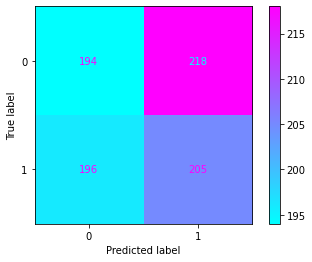

In [13]:
#plot confusion matrix for dummy classifier
plot_confusion_matrix(dummy_clf,X_test,y_test,cmap='cool',values_format='g')
plt.show()

#### Logistic Regression with GridCV


In [14]:
#logreg model
logreg=LogisticRegression()
penalty = ['l2']
c_range = [0.001, 0.01, 0.1, 1]
solver=['lbfgs']
parameters_lr = dict(C=c_range, penalty=penalty,solver=solver)
lr_1=GridSearchCV(logreg,parameters_lr,scoring='accuracy',cv=5,verbose=1)



In [15]:
#training model and predicting on test set
lr_1.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

In [16]:
examinebestmodel(lr_1)

0.9993160989777017
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=1)


In [17]:
#predict on test set - logreg
y_pred_lr_1=lr_1.best_estimator_.predict(X_test)
results_dict['Log_Reg']=getresults(y_test,y_pred_lr_1)
getresults(y_test,y_pred_lr_1)

('F1:', 0.9987515605493134, 'Accuracy:', 0.998769987699877)

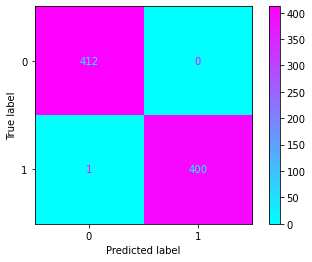

In [18]:
#plotting confusion matrix for LR model
plot_confusion_matrix(lr_1.best_estimator_,X_test,y_test,cmap='cool',values_format='g')
plt.show()

#### Decision Tree with GridCV
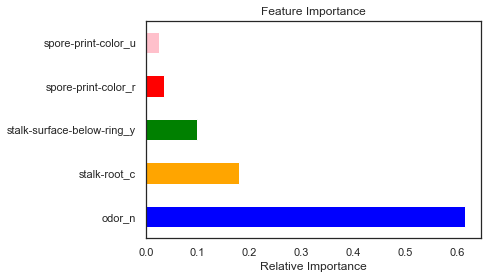

In [19]:
dtc= DecisionTreeClassifier(random_state=1)
param_grid={'max_depth': [1,11,15],
            'min_samples_leaf': [2,10,30],
            'splitter': ['best','random'],
            'criterion':['gini','entropy']}
dtc_grid=GridSearchCV(dtc, param_grid, cv=3,verbose=1)       

In [20]:
dtc_grid.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 11, 15],
                         'min_samples_leaf': [2, 10, 30],
                         'splitter': ['best', 'random']},
             verbose=1)

In [21]:
examinebestmodel(dtc_grid)

0.9997264396115443
{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2, 'splitter': 'best'}
DecisionTreeClassifier(max_depth=11, min_samples_leaf=2, random_state=1)


In [22]:
y_pred_gridtree=dtc_grid.best_estimator_.predict(X_test)
getresults(y_test,y_pred_gridtree)

('F1:', 1.0, 'Accuracy:', 1.0)

In [23]:
results_dict['DTC_Grid']=getresults(y_test,y_pred_gridtree)

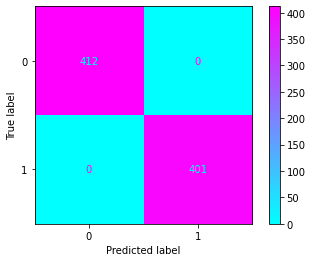

In [24]:
#confusion matrix for DTC 
plot_confusion_matrix(dtc_grid.best_estimator_,X_test,y_test,cmap='cool',values_format='g')
plt.show()

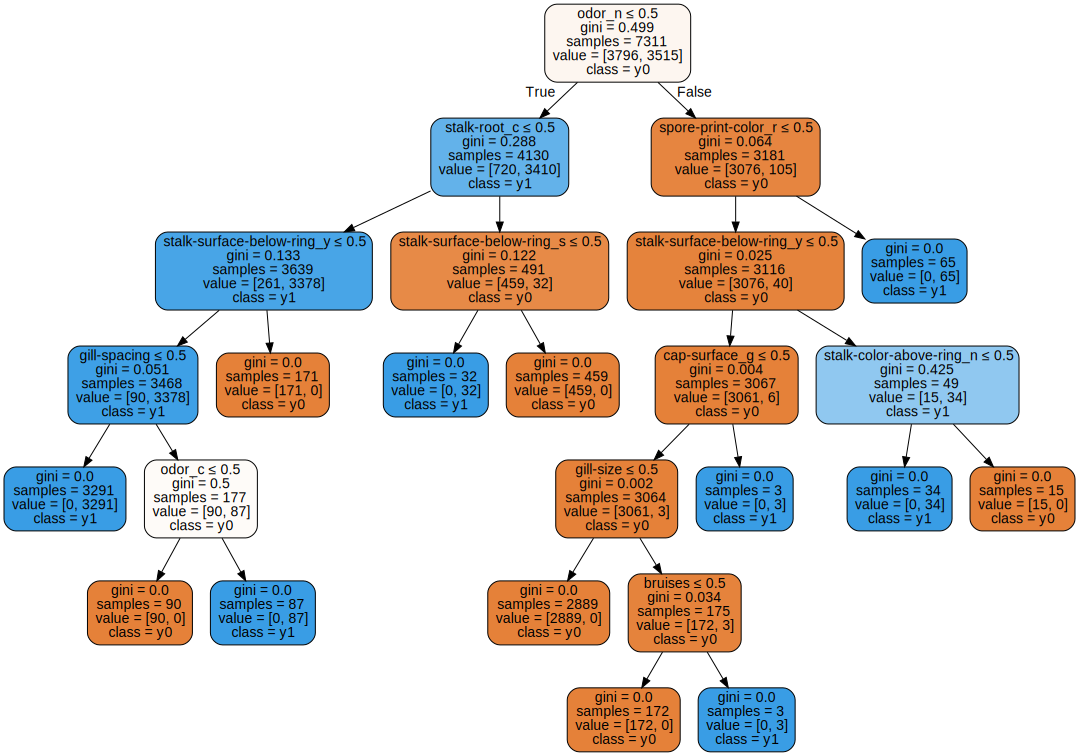

In [25]:
#graphviz visualization of decision tree best estimator
import graphviz 
import sklearn.tree
dot_data=sklearn.tree.export_graphviz(dtc_grid.best_estimator_,out_file=None,feature_names = list(X.columns),class_names=True, filled=True,rounded=True,special_characters=True)
graph=graphviz.Source(dot_data)
graph

In [35]:
#feature importance scores
feat_importanceDF = pd.DataFrame(dtc_grid.best_estimator_.feature_importances_,index=X.columns)
feat_importanceDF.sort_values(by=0,ascending=False).head(10)

,0
odor_n,0.618633
stalk-root_c,0.176590
stalk-surface-below-ring_y,0.097371
spore-print-color_r,0.033998
odor_c,0.024239
gill-spacing,0.023795
stalk-surface-below-ring_s,0.016391
stalk-color-above-ring_n,0.005703
cap-surface_g,0.001639
bruises,0.001616


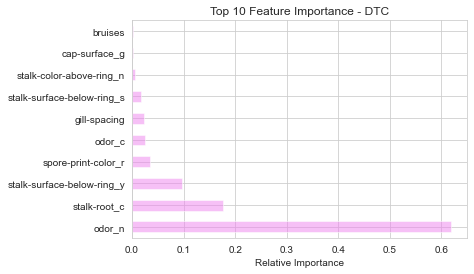

In [45]:
#plotting top 10 features
feat_importances = pd.Series(dtc_grid.best_estimator_.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='violet', alpha=0.5)
plt.title("Top 10 Feature Importance - DTC")
plt.xlabel('Relative Importance')
plt.show()